In [176]:
#Traditional ML methods on portfolio of contracts: Adaboost and Random Forests


#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pdblp   #for Bloomberg API
import os
import sys


# global variables
#BBDATACACHEPATH = 'bbcache/';      # MUST END IN /
#a = os.makedirs(BBDATACACHEPATH, exist_ok=1 )  
#BBCACHE = {} # mem cache of BB loads, to limit loads

#inputs
aum=500000000 #Money under management
assets = ['CO1 COMDTY','SP1 INDEX','TY1 COMDTY','HG1 COMDTY', 'NQ1 INDEX', 'GC1 COMDTY']
#Brent futures, Sp500 futures, 10-year Treasuries futures, Copper futures, Nasdaq futures, Gold futures
lot_size=[1000,250,1000,250,20,100] #1 point move generates that amount in USD (per asset)
start_date='20000101'
end_date='20200807'

##########################FUNCTIONS TO BE USED### CAN BE PUT IN LIBRARY LATER#############

#Load data from Bloomberg

def bbloadML(ticker, start_date,end_date):
    
    #global BBCACHE
    #name = ticker[:3]

    #if ticker in BBCACHE:
    #    a = BBCACHE[ticker]
    #    print('USING CACHED')

    #else:

    con = pdblp.BCon(debug=False, port=8194, timeout=5000)
    con.start()
    a = con.bdh(ticker, ['PX_LAST', 'FUT_AGGTE_VOL'],  start_date, end_date )
    a.columns=['close','volume']

        #save as csv just in case
        #global BBDATACACHEPATH
        #fn = BBDATACACHEPATH+ticker+'.csv'
        #a.to_csv(fn)
        #print('Saved to '+fn)

        #cache
        #BBCACHE[ticker] = a
 
    return a

# Take a dataframe of daily prices, volume and open interest, and output dataframe of daily features (for each contract)
def featureML(df):
    # returns. Can be adjusted later for futures rolls (overwritten)
    df1=pd.DataFrame()
    df1['ret']=np.log(df.close/df.close.shift(1))
    # df1['oi']=(df.oi/df.oi.shift(1))-1 #change in total open interest in percentage 
    # (not using OI for now as we do not get this number a few hours after close. 
    # could be used to trading next day at open though, but a few nan issues)
    #df1['volume']=(df.volume/df.volume.shift(1))-1 #daily change in total volume in percentage
    #df1['volume1M']=(df.volume/df.volume.rolling(40).mean())-1 #change in total volume relative to monthly ma in percentage
    df1['ma50']=df.close/df.close.rolling(50).mean()-1 #how much above or below we are relative to 50 day moving average in %
    df1['ma8']=df.close/df.close.rolling(8).mean()-1 #how much above or below we are relative to 8 day moving average in %
    df1['ma20']=df.close/df.close.rolling(20).mean()-1 #how much above or below we are relative to 20 day moving average in %
    df1['ma100']=df.close/df.close.rolling(100).mean()-1 #how much above or below we are relative to 100 day moving average in %
    df1['ma200']=df.close/df.close.rolling(200).mean()-1 #how much above or below we are relative to 200 day moving average in %
    df1['RSI']=rsi(df.close,14)/100 #RSI 14 days
    df1['volatility']=df1.ret.rolling(20).std()*np.sqrt(252) #historical 20-day volatility annualized
    df1['volatility1M']=df1.volatility-df1.volatility.rolling(20).mean() #historical 20-day volatility annualized
    #not using implied vol for now as many nan
    return df1

#RSI function
def rsi(prices, n=14):
    pricediff=prices-prices.shift(1)
    upmove=pd.Series()
    downmove=pd.Series()
    RS=pd.Series()
    RSI=pd.Series()
    upmove=pd.Series([pricediff[i] if pricediff[i]>0 else 0 for i in range(len(pricediff))])
    downmove=pd.Series([-pricediff[i] if pricediff[i]<0 else 0 for i in range(len(pricediff))])
    RS=upmove.rolling(n).mean()/downmove.rolling(n).mean()
    RSI=100-100/(1+RS)
    RSI.index=prices.index
    return RSI
    
# sharpe for return series (the standard)
def	sharpe(logret):
    n = len(logret)
    p=np.exp(logret.sum())**(252/n)-1
    s=np.std(logret)*np.sqrt(252)
    return p/s    

def annreturn(logret):
    n = len(logret)
    r=np.exp(logret.sum())**(252/n)-1
    return r 



In [177]:
prices_dict=dict()
features_dict=dict()
for asset in assets:
    print("##### Loading "+asset+" and creating features dataframe\n")
    prices = bbloadML(asset, start_date,end_date).dropna()
    features = featureML(prices)
    prices_dict[asset[:3]]=prices
    features_dict[asset[:3]]=features.dropna()




##### Loading CO1 COMDTY and creating features dataframe

##### Loading SP1 INDEX and creating features dataframe

##### Loading TY1 COMDTY and creating features dataframe

##### Loading HG1 COMDTY and creating features dataframe

##### Loading NQ1 INDEX and creating features dataframe

##### Loading GC1 COMDTY and creating features dataframe



Confusion matrix for Adaboost on test set for CO1:  [[462 482]
 [775 823]]
AdaBoost accuracy on test set for CO1:  0.505507474429583
Confusion matrix for Adaboost on train set for CO1:  [[ 619  317]
 [ 598 1007]]
AdaBoost accuracy on train set for CO1:  0.6399055489964581


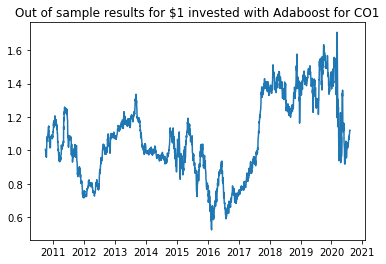

Confusion matrix for Adaboost on test set for SP1:  [[ 284  376]
 [ 828 1025]]
AdaBoost accuracy on test set for SP1:  0.520891364902507
Confusion matrix for Adaboost on train set for SP1:  [[ 504  241]
 [ 638 1129]]
AdaBoost accuracy on train set for SP1:  0.6500796178343949


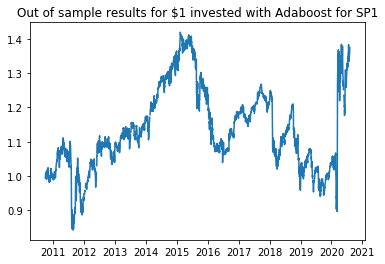

Confusion matrix for Adaboost on test set for TY1:  [[406 482]
 [754 849]]
AdaBoost accuracy on test set for TY1:  0.5038137294259334
Confusion matrix for Adaboost on train set for TY1:  [[ 529  266]
 [ 614 1081]]
AdaBoost accuracy on train set for TY1:  0.6465863453815262


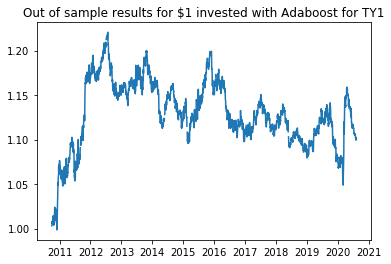

Confusion matrix for Adaboost on test set for HG1:  [[523 537]
 [710 709]]
AdaBoost accuracy on test set for HG1:  0.49697458652682536
Confusion matrix for Adaboost on train set for HG1:  [[666 371]
 [518 924]]
AdaBoost accuracy on train set for HG1:  0.6413876563130294


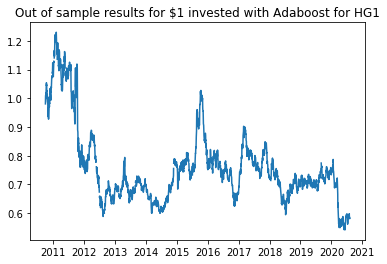

Confusion matrix for Adaboost on test set for NQ1:  [[ 289  359]
 [ 795 1071]]
AdaBoost accuracy on test set for NQ1:  0.5409705648369133
Confusion matrix for Adaboost on train set for NQ1:  [[ 574  303]
 [ 601 1035]]
AdaBoost accuracy on train set for NQ1:  0.6402705929168325


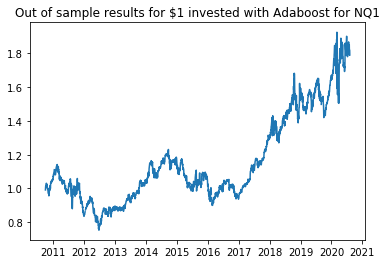

Confusion matrix for Adaboost on test set for GC1:  [[339 367]
 [868 905]]
AdaBoost accuracy on test set for GC1:  0.5018152480839048
Confusion matrix for Adaboost on train set for GC1:  [[ 500  273]
 [ 629 1077]]
AdaBoost accuracy on train set for GC1:  0.63614360629286


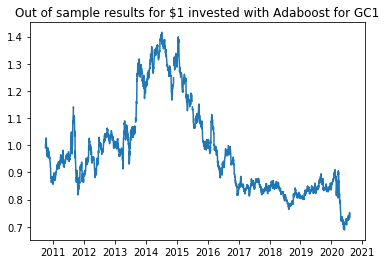

Portfolio Sharpe out of sample:  0.12
Annualized returns out of sample:  0.0113
Annualized volatility out of sample:  0.09337628552554515


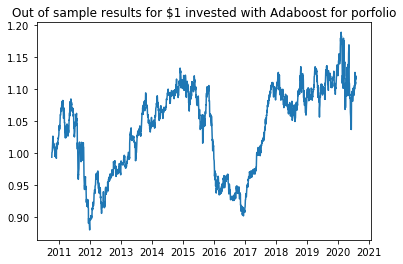

In [195]:


Ada = AdaBoostClassifier(n_estimators=100,random_state=0)
test_size=0.5
cumpath=pd.DataFrame()
oosreturn=pd.DataFrame()
#AdaBoost on all assets. Putting equal weight in each strategy at start

for asset in assets:
    name=asset[:3]
    X=features_dict[name]
    Y=np.sign(features_dict[name].ret.shift(-1)[:-1])
    mask=[i for i in range(len(Y)) if Y[i]==0]
    Y[mask]=1.
    Y=Y.astype(int)
    X_train, X_test, Y_train, Y_test = train_test_split(X[:-1], Y, test_size=test_size, shuffle=False, random_state=42)
    Ada.fit(X_train,Y_train)
    Ypred_ada = Ada.predict(X_test)
    print("Confusion matrix for Adaboost on test set for "+name+": ",confusion_matrix(Y_test,Ypred_ada).T)
    print("AdaBoost accuracy on test set for "+name+": ",accuracy_score(Y_test, Ypred_ada))
    Ypred_ada_train = Ada.predict(X_train)
    print("Confusion matrix for Adaboost on train set for "+name+": ",confusion_matrix(Y_train,Ypred_ada_train).T)
    print("AdaBoost accuracy on train set for "+name+": ",accuracy_score(Y_train, Ypred_ada_train))
    oosreturn[name]=Ypred_ada*X_test.ret.shift(-1)
    cumpath[name]=oosreturn[name].cumsum().apply(np.exp)
    plt.plot(cumpath[name])
    plt.title("Out of sample results for $1 invested with Adaboost for "+name)
    plt.show()

plt.plot(cumpath.dropna().mean(axis=1)) #Only trading when all contracts are trading on a given day
plt.title("Out of sample results for $1 invested with Adaboost for porfolio")

n=len(cumpath.dropna().mean(axis=1))
totret=cumpath.dropna().mean(axis=1)[-1]-1
anret=(totret+1)**(252/n)-1
averageret=cumpath.dropna().mean(axis=1)/cumpath.dropna().mean(axis=1).shift(1)-1
avgvol=np.std(averageret)*np.sqrt(252)
sharperatio=anret/avgvol
print("Portfolio Sharpe out of sample: ",round(sharperatio,2))
print("Annualized returns out of sample: ", round(anret,4))
print("Annualized volatility out of sample: ", avgvol)

Confusion matrix for RandomForest on test set for CO1:  [[569 657]
 [668 648]]
RandomForest accuracy on test set for CO1:  0.478756884343037
Confusion matrix for RandomForest on train set for CO1:  [[1217    0]
 [   0 1324]]
RandomForest accuracy on train set for CO1:  1.0


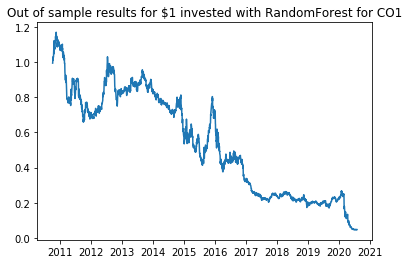

Confusion matrix for RandomForest on test set for SP1:  [[427 568]
 [685 833]]
RandomForest accuracy on test set for SP1:  0.5013927576601671
Confusion matrix for RandomForest on train set for SP1:  [[1142    0]
 [   0 1370]]
RandomForest accuracy on train set for SP1:  1.0


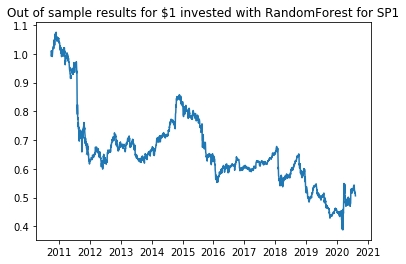

Confusion matrix for RandomForest on test set for TY1:  [[539 628]
 [621 703]]
RandomForest accuracy on test set for TY1:  0.4985949417904456
Confusion matrix for RandomForest on train set for TY1:  [[1143    0]
 [   0 1347]]
RandomForest accuracy on train set for TY1:  1.0


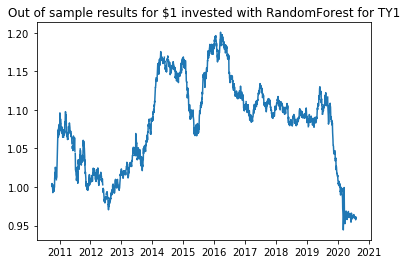

Confusion matrix for RandomForest on test set for HG1:  [[655 640]
 [578 606]]
RandomForest accuracy on test set for HG1:  0.5086728519564341
Confusion matrix for RandomForest on train set for HG1:  [[1184    0]
 [   0 1295]]
RandomForest accuracy on train set for HG1:  1.0


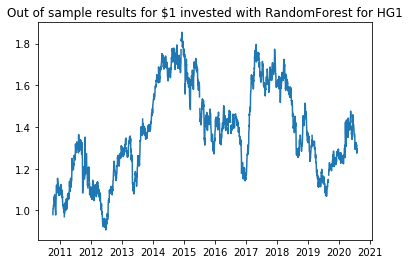

Confusion matrix for RandomForest on test set for NQ1:  [[467 567]
 [617 863]]
RandomForest accuracy on test set for NQ1:  0.5290373906125696
Confusion matrix for RandomForest on train set for NQ1:  [[1175    0]
 [   0 1338]]
RandomForest accuracy on train set for NQ1:  1.0


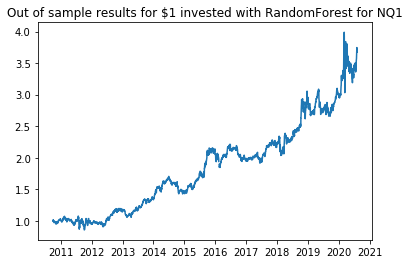

Confusion matrix for RandomForest on test set for GC1:  [[432 463]
 [775 809]]
RandomForest accuracy on test set for GC1:  0.5006050826946349
Confusion matrix for RandomForest on train set for GC1:  [[1129    0]
 [   0 1350]]
RandomForest accuracy on train set for GC1:  1.0


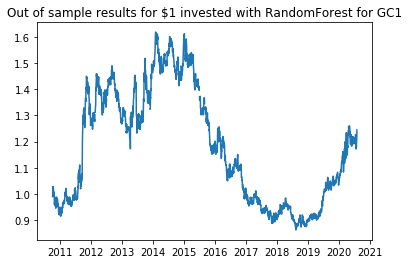

Portfolio Sharpe out of sample:  0.28
Annualized returns out of sample:  0.0261
Annualized volatility out of sample:  0.09155279624952825


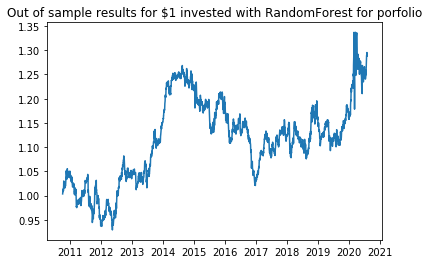

In [196]:
RF = RandomForestClassifier(n_estimators=50,random_state=0)


test_size=0.5
cumpath=pd.DataFrame()
oosreturn=pd.DataFrame()
#RandomForest on all assets. Putting equal weight in each strategy at start

for asset in assets:
    name=asset[:3]
    X=features_dict[name]
    Y=np.sign(features_dict[name].ret.shift(-1)[:-1])
    mask=[i for i in range(len(Y)) if Y[i]==0]
    Y[mask]=1.
    Y=Y.astype(int)
    X_train, X_test, Y_train, Y_test = train_test_split(X[:-1], Y, test_size=test_size, shuffle=False, random_state=42)
    RF.fit(X_train,Y_train)
    Ypred_rf = RF.predict(X_test)
    print("Confusion matrix for RandomForest on test set for "+name+": ",confusion_matrix(Y_test,Ypred_rf).T)
    print("RandomForest accuracy on test set for "+name+": ",accuracy_score(Y_test, Ypred_rf))
    Ypred_rf_train = RF.predict(X_train)
    print("Confusion matrix for RandomForest on train set for "+name+": ",confusion_matrix(Y_train,Ypred_rf_train).T)
    print("RandomForest accuracy on train set for "+name+": ",accuracy_score(Y_train, Ypred_rf_train))
    oosreturn[name]=Ypred_rf*X_test.ret.shift(-1)
    cumpath[name]=oosreturn[name].cumsum().apply(np.exp)
    plt.plot(cumpath[name])
    plt.title("Out of sample results for $1 invested with RandomForest for "+name)
    plt.show()

plt.plot(cumpath.dropna().mean(axis=1)) #Only trading when all contracts are trading on a given day
plt.title("Out of sample results for $1 invested with RandomForest for porfolio")

n=len(cumpath.dropna().mean(axis=1))
totret=cumpath.dropna().mean(axis=1)[-1]-1
anret=(totret+1)**(252/n)-1
averageret=cumpath.dropna().mean(axis=1)/cumpath.dropna().mean(axis=1).shift(1)-1
avgvol=np.std(averageret)*np.sqrt(252)
sharperatio=anret/avgvol
print("Portfolio Sharpe out of sample: ",round(sharperatio,2))
print("Annualized returns out of sample: ", round(anret,4))
print("Annualized volatility out of sample: ", avgvol)

The out of sample results for Random Forest (putting equal amount in each asset class) are better than for AdaBoost. But both are not great: marginal annualized return (2.6% and 1.2%) and Sharpe ratios of 0.28 and 0.12 respectively. 
It does not look statistically significant, and it does not look like the models learn, so doing a rolling training window would probably not bring better results.
The double portfolio optimization of ATS approach shown in the other notebook (main_notebook), brings much better results with more stability. We will therefore focus on that in the presentation.
